# Esse resultado foi feito segundo a otimização anterior que eu fiz

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
# A massa molar, extraída da foŕmula quimica que o artigo passa é:
M = 0.540273 #kg/mol
#M = 2 #kg/mol

delta_S_p2_rev_comp = pd.read_csv("delta_S_p2_rev_comp.csv",header = None).rename(columns={0:"T(K)",1:"DS(J/kgK)"})
delta_S_p2_rev_decomp = pd.read_csv("delta_S_p2_rev_decomp.csv",header = None).rename(columns={0:"T(K)",1:"DS(J/kgK)"})
delta_S_p2_comp = pd.read_csv("delta_S_p2_comp.csv",header = None).rename(columns={0:"T(K)",1:"DS(J/kgK)"})
delta_S_p2_decomp = pd.read_csv("delta_S_p2_decomp.csv",header = None).rename(columns={0:"T(K)",1:"DS(J/kgK)"})

########################################################## Parâmetros ##########################################################
# Parâmetros

T_0 = 310 # Em Kelvin
delta_V = 43e-30 # A unidade dá em metros ao cubo.
k_B = 1.380649e-23 # Em J/K

g = 4469.97
Delta_0 = 2580.11
g = 18861
Delta_0=3043
T_0=210
#Parâmetros ajustados: {'g': 14999.999999999709, 'Delta0': 2971.765305283768, 'T0': 200.00000000000003}
#Parâmetros ajustados: {'g': 18861.72554952473, 'Delta0': 3043.873903460785, 'T0': 200.00000000000003}
#g=3258.535790407055
#Delta_0=2493.0988732172227
########################################################## Distribuição de Spin ##########################################################
def T(m, delta_0, delta_V, P, g, T0):

    P_linha = (((delta_V) * P)) / 4

    gamma = (delta_0 + P_linha/k_B) / (T0)
    numerator = 2 * (m - gamma)
    denominator = np.log((m + 1) / (g**2 * (1 - m)))
    return T0 * (numerator / denominator)

# Varredura original em m
m_amb = np.linspace(-0.999, 0.999, 10000)
m_2kbar = np.linspace(-0.999, 0.999, 10000)

Temp_amb = T(m_amb, Delta_0, delta_V, 101325, g, T_0)
Temp_2kbar = T(m_2kbar, Delta_0, delta_V, 200e6, g, T_0)

n_hs_amb = (m_amb + 1) / 2
n_hs_2kbar = (m_2kbar + 1) / 2

# Define um grid comum de temperatura (exemplo: de 1K a 300K)
T_min = max(np.min(Temp_amb), np.min(Temp_2kbar))
T_max = min(np.max(Temp_amb), np.max(Temp_2kbar))
T_common = np.linspace(T_min, T_max, 1000)

# Interpolação para obter n_hs em T_common
n_hs_amb_interp = np.interp(T_common, Temp_amb, n_hs_amb)
n_hs_2kbar_interp = np.interp(T_common, Temp_2kbar, n_hs_2kbar)

m_amb = np.linspace(-0.999, 0.999, 10000)
m_2kbar = np.linspace(-0.999, 0.999, 10000)

Temp_amb = T(m_amb, Delta_0, delta_V, 101325, g, T_0)
Temp_2kbar = T(m_2kbar, Delta_0, delta_V, 200e6, g, T_0)
n_hs_amb = (m_amb + 1) / 2
n_hs_2kbar = (m_2kbar + 1) / 2

########################################################## Entropia Configuracional ##########################################################
R = 8.314 # Em J/molK

def S_C(n_hs):
    S = -R/M*(n_hs*np.log(n_hs) + (1-n_hs)*np.log(1-n_hs))
    return S

S_C_amb = S_C(n_hs_amb_interp)
S_C_2kbar = S_C(n_hs_2kbar_interp)
delta_S_Config = -(S_C_2kbar-S_C_amb)
########################################################## Entropia de Spin ##########################################################
def S_S(T, g_J, J, B):
    """
    Calcula a entropia magnética (em J/mol·K) de um paramagneto ideal de spin J.

    Entradas:
    - T : Temperatura (K)
    - g_J : Fator de Landé
    - J : Momento total de spin
    - B : Campo magnético (Tesla)

    Saída:
    - S : Entropia (J/mol·K)
    """
    k_B = 1.380649e-23      # J/K
    mu_B = 9.2740100783e-24 # J/T
    R = 8.314462618         # J/mol·K

    x = (g_J * mu_B * J * B) / (k_B * T)

    num = np.sinh((2 * J + 1) * x / (2 * J))
    den = np.sinh(x / (2 * J))
    Z = num / den

    coeff = (2 * J + 1) / (2 * J)
    B_J = (coeff / np.tanh(coeff * x)) - (1 / (2 * J * np.tanh(x / (2 * J))))

    S = R/M* (np.log(Z) + x * B_J)
    return S

S_S_amb = n_hs_amb_interp*S_S(T_common, 2, 2,0.01)
S_S_2kbar = n_hs_2kbar_interp*S_S(T_common, 2, 2,0.01)

delta_S_Spin = -(S_S_2kbar - S_S_amb)
########################################################## Entropia Óptica ##########################################################
def S_O(limite_soma, T, frequencias_cm):
    """
    Calcula a expressão da imagem com frequências em cm^-1.

    Parâmetros:
    limite_soma (int): Número de termos da soma.
    T (float): Temperatura em Kelvin.
    frequencias_cm (list ou array): Lista de frequências (em cm^-1).

    Retorno:
    float: Valor da expressão (J/mol·K).
    """
    k_B = 1.380649e-23       # J/K
    hbar = 1.054571817e-34   # J.s
    c = 1        # 
    R = 8.314462618          # J/mol·K

    beta = 1 / (k_B * T)
    soma = 0.0

    if len(frequencias_cm) != limite_soma:
        raise ValueError(f"O número de frequências ({len(frequencias_cm)}) não bate com o limite da soma ({limite_soma}).")

    for omega_cm in frequencias_cm:
        omega = 2 * np.pi * c * omega_cm  # Convertendo de cm^-1 para rad/s
        x = beta * hbar * omega

        if x == 0:
            continue  # Evita divisão por zero

        termo_log = -np.log(1 - np.exp(-x))
        termo_fracao = x / (np.exp(x) - 1)

        soma += termo_log + termo_fracao

    return R /M* soma


#frequencias_HS = [20,545.3,965.2]
#frequencias_LS = [74,545.6,968.5]
#frequencias_HS = [20,545.3,965.2,1500,3000,5000]
#frequencias_LS = [74,545.6,968.5,1500,3000,5000]
#limite_soma = len(frequencias_HS)
data = pd.read_csv("modos_normais_oct.csv",decimal=",")
frequencias_HS = data[data["HighSpin"]<900]["HighSpin"]
frequencias_LS = data[data["LowSpin"]<900]["LowSpin"]
limite_soma = len(frequencias_HS)
#frequencias_HS = [69.2,472.4,652.1]
#frequencias_LS = [63.6,238.1,608.8]
#limite_soma = 3
temperaturas = T_common  # Temperaturas de 10K a 500K

# Calculando S para cada temperatura
#S_valores = [S_O(limite_soma, T, frequencias_cm) for T in temperaturas]
S_O_HS = [S_O(limite_soma, T, frequencias_HS) for T in temperaturas]
S_O_LS = [S_O(limite_soma, T, frequencias_LS) for T in temperaturas]

S_O_2kbar = n_hs_2kbar_interp*S_O_HS + (1-n_hs_2kbar_interp)*S_O_LS
S_O_amb =  n_hs_amb_interp*S_O_HS + (1-n_hs_amb_interp)*S_O_LS
delta_S_O = -(S_O_2kbar-S_O_amb)
delta_S_total = delta_S_Config + delta_S_Spin + delta_S_O
########################################################## Plot dos Gráficos ##########################################################
plt.figure(figsize=(12, 8))
plt.xlim(275,350)

data = pd.read_csv("delta_S_p2_rev_comp.csv",header=None).rename(columns={0:"T(K)",2:"DS(J/kgK)"})
T_exp = data["T(K)"].values
DS_exp = data["DS(J/kgK)"].values
plt.scatter(T_exp,DS_exp,label="Experimental",color="black")

plt.scatter(delta_S_p2_rev_comp['T(K)'],delta_S_p2_rev_comp['DS(J/kgK)'],color = 'black',label='Experimental')
plt.plot(T_common,delta_S_O,label='$\Delta S_{opt}$')
plt.plot(T_common, delta_S_Spin,label='$\Delta S_{spin}$')
plt.plot(T_common,delta_S_Config,label='$\Delta S_{config}$')
plt.plot(T_common,delta_S_total,label='$\Delta S_{total}$=$\Delta S_{spin}$+$\Delta S_{config}+\Delta S_{opt}$', linewidth=3)
plt.xlim(290,350)
plt.xlabel("Temperature (K)")
plt.ylabel("$\Delta$S (J/Kg K)")
plt.legend()


plt.show()

<>:183: SyntaxWarning: invalid escape sequence '\D'
<>:184: SyntaxWarning: invalid escape sequence '\D'
<>:185: SyntaxWarning: invalid escape sequence '\D'
<>:186: SyntaxWarning: invalid escape sequence '\D'
<>:189: SyntaxWarning: invalid escape sequence '\D'
<>:183: SyntaxWarning: invalid escape sequence '\D'
<>:184: SyntaxWarning: invalid escape sequence '\D'
<>:185: SyntaxWarning: invalid escape sequence '\D'
<>:186: SyntaxWarning: invalid escape sequence '\D'
<>:189: SyntaxWarning: invalid escape sequence '\D'
C:\Users\55219\AppData\Local\Temp\ipykernel_18732\3789123151.py:183: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(T_common,delta_S_O,label='$\Delta S_{opt}$')
C:\Users\55219\AppData\Local\Temp\ipykernel_18732\3789123151.py:184: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(T_common, delta_S_Spin,label='$\Delta S_{spin}$')
C:\Users\55219\AppData\Local\Temp\ipykernel_18732\3789123151.py:185: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(T_common,delt

ValueError: O número de frequências (78) não bate com o limite da soma (77).

# Minimos Quadrados. O resultado não foi muito diferente do caso acima. 

## Fit considerando as três frequencias obtidas via histograma

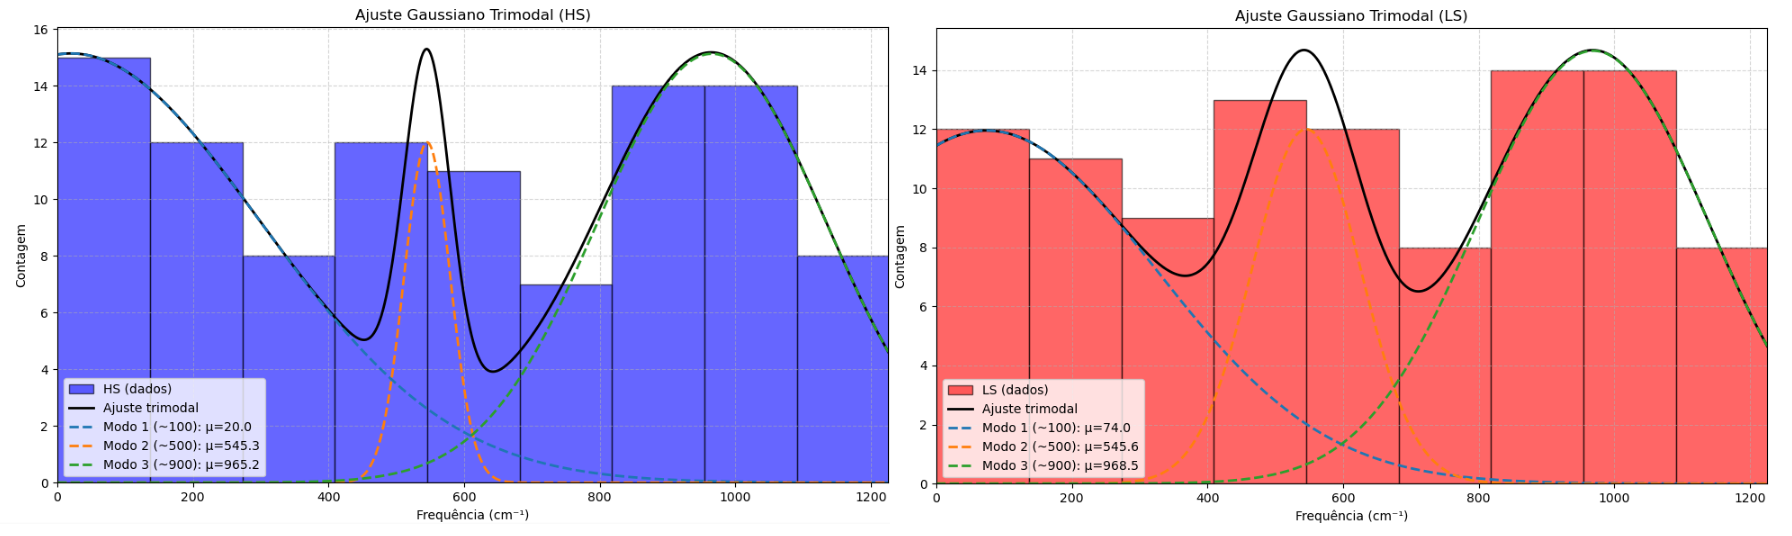

Parâmetros ajustados: {'g': 91995.93064057393, 'Delta0': 3517.588609600646, 'T0': 262.3603719658542}


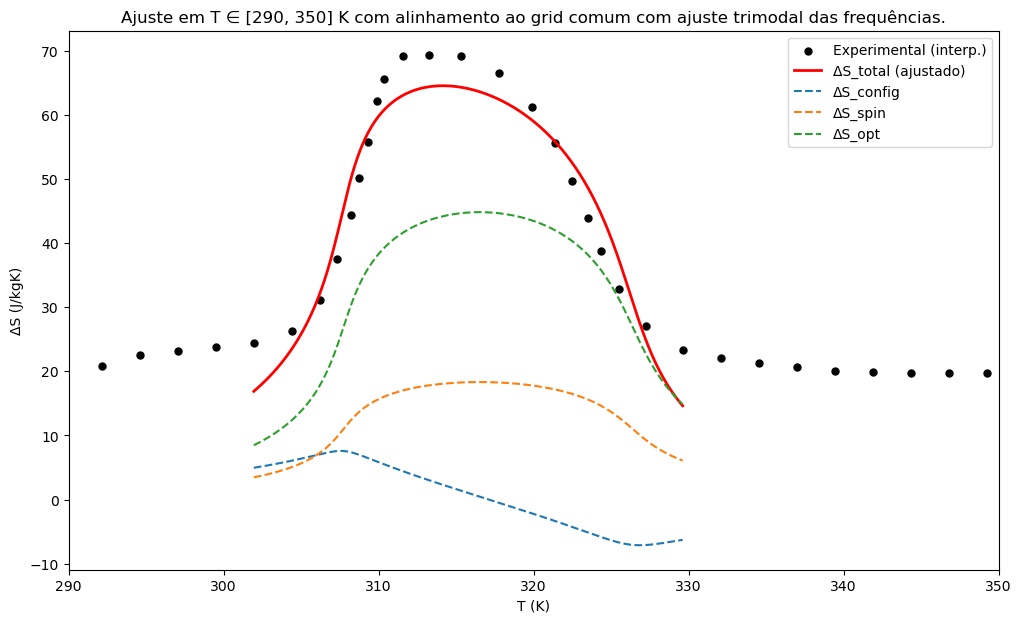

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from random import randint
data = pd.read_csv("modos_normais_oct.csv",decimal=",")
##########################################################
# Constantes
##########################################################
R = 8.314 # J/molK
k_B = 1.380649e-23
mu_B = 9.2740100783e-24
M = 0.540273 # kg/mol

##########################################################
# Frequencias utilizadas
##########################################################
data = pd.read_csv("modos_normais_oct.csv",decimal=",")
#frequencias_HS = data[data["HighSpin"]<1000]["HighSpin"]
#frequencias_LS = data[data["LowSpin"]<1000]["LowSpin"]
#freq_HS = data["HighSpin"]
#freq_LS = data["LowSpin"]
#freq_HS = list(freq_HS)
#freq_LS = list(freq_LS)
frequencias_HS=(20,20,20,545.3,545.3,545.3,965.2,965.2,965.2)
frequencias_LS=(74,74,74,545.6,545.6,545.6,968.5,968.5,968.5)

##########################################################

##########################################################
# Funções auxiliares
##########################################################
def T_model(m, delta_0, delta_V, P, g, T0):
    P_linha = (((delta_V) * P)) / 4
    gamma = (delta_0 + P_linha/k_B) / (T0)
    numerator = 2 * (m - gamma)
    denominator = np.log((m + 1) / (g**2 * (1 - m)))
    return T0 * (numerator / denominator)

def S_C(n_hs):
    return -R/M*(n_hs*np.log(n_hs) + (1-n_hs)*np.log(1-n_hs))

def S_S(T, g_J, J, B):
    x = (g_J * mu_B * J * B) / (k_B * T)
    num = np.sinh((2 * J + 1) * x / (2 * J))
    den = np.sinh(x / (2 * J))
    Z = num / den
    coeff = (2 * J + 1) / (2 * J)
    B_J = (coeff / np.tanh(coeff * x)) - (1 / (2 * J * np.tanh(x / (2 * J))))
    return R/M * (np.log(Z) + x * B_J)

def S_O(limite_soma, T, frequencias_cm):
    hbar = 1.054571817e-34
    c = 1
    beta = 1/(k_B*T)
    soma = 0.0
    for omega_cm in frequencias_cm:
        omega = 2*np.pi*c*omega_cm
        x = beta*hbar*omega
        if x == 0: 
            continue
        termo_log = -np.log(1 - np.exp(-x))
        termo_fracao = x/(np.exp(x) - 1)
        soma += termo_log + termo_fracao
    return R/M * soma

##########################################################
# Cálculo de ΔS e componentes no grid pedido (T_common)
##########################################################
def calc_deltaS_components(params, fixed, T_common, P_amb=101325, P_high=200e6,
                           freq_HS=frequencias_HS, freq_LS=frequencias_LS):
    # Usa valores fixos + ajustáveis
    T0      = params.get("T0",     fixed["T0"])
    g       = params.get("g",      fixed["g"])
    Delta0  = params.get("Delta0", fixed["Delta0"])
    delta_V = params.get("deltaV", fixed["deltaV"])

    # Varredura em m -> gera T(m) para 1 atm e 2 kbar
    m_vals = np.linspace(-0.999, 0.999, 10000)
    Temp_amb  = T_model(m_vals, Delta0, delta_V, P_amb,  g, T0)
    Temp_high = T_model(m_vals, Delta0, delta_V, P_high, g, T0)
    n_hs_vals = (m_vals+1)/2

    # Interpolar fração HS para T_common
    n_hs_amb  = np.interp(T_common, Temp_amb,  n_hs_vals)
    n_hs_high = np.interp(T_common, Temp_high, n_hs_vals)

    # (1) Configuracional
    delta_S_Config = -(S_C(n_hs_high) - S_C(n_hs_amb))

    # (2) Spin
    S_S_amb  = n_hs_amb  * S_S(T_common, 2, 2, 0.01)
    S_S_high = n_hs_high * S_S(T_common, 2, 2, 0.01)
    delta_S_Spin = -(S_S_high - S_S_amb)

    # (3) Óptica
    freq_HS=list(frequencias_HS)
    freq_LS=list(frequencias_LS)
    S_O_HS = np.array([S_O(len(freq_HS), T, freq_HS) for T in T_common])
    S_O_LS = np.array([S_O(len(freq_LS), T, freq_LS) for T in T_common])
    S_O_high = n_hs_high*S_O_HS + (1-n_hs_high)*S_O_LS
    S_O_amb  = n_hs_amb *S_O_HS + (1-n_hs_amb )*S_O_LS
    delta_S_O = -(S_O_high - S_O_amb)

    delta_S_total = delta_S_Config + delta_S_Spin + delta_S_O
    return delta_S_total, delta_S_Config, delta_S_Spin, delta_S_O

##########################################################
# Alinhar dados ao grid comum e limitar intervalo de fit
##########################################################
def align_to_common_grid(T_exp, DS_exp, T_range=None, n_points=None):
    """Cria T_common igualmente espaçado dentro de T_range
       e interpola DS_exp para T_common.
    """
    # Limpeza, ordenação e máscara de intervalo
    T_exp = np.asarray(T_exp)
    DS_exp = np.asarray(DS_exp)
    # ordenar
    order = np.argsort(T_exp)
    T_exp = T_exp[order]
    DS_exp = DS_exp[order]
    # remover temperaturas duplicadas (mantém a média do DS nelas)
    T_unique, idxs = np.unique(T_exp, return_index=True)
    if len(T_unique) != len(T_exp):
        # média por temperatura
        df_tmp = pd.DataFrame({"T":T_exp, "DS":DS_exp}).groupby("T", as_index=False).mean()
        T_exp = df_tmp["T"].values
        DS_exp = df_tmp["DS"].values

    # intervalo
    if T_range is not None:
        tmin, tmax = T_range
        mask = (T_exp >= tmin) & (T_exp <= tmax)
        T_exp = T_exp[mask]
        DS_exp = DS_exp[mask]

    if n_points is None:
        n_points = len(T_exp)  # por padrão: mesmo nº de pontos do experimento no intervalo

    # criar grid comum e interpolar DS experimental nele
    T_common = np.linspace(T_exp.min(), T_exp.max(), 500)
    DS_exp_common = np.interp(T_common, T_exp, DS_exp)

    return T_common, DS_exp_common

##########################################################
# Rotina de ajuste (com intervalo e alinhamento)
##########################################################
def fit_params(T_exp, DS_exp, to_fit=("g","Delta0"),
               init_guess={"T0":310,"g":4000,"Delta0":2500,"deltaV":43e-30},
               bounds={"T0":(200,400),"g":(1000,10000),"Delta0":(1000,5000),"deltaV":(1e-31,1e-28)},
               T_range=(290,350), n_points=None,
               freq_HS=frequencias_HS, freq_LS=frequencias_LS,
               P_amb=101325, P_high=200e6):

    # Alinhar e interpolar experimental → T_common no intervalo escolhido
    T_common, DS_exp_common = align_to_common_grid(T_exp, DS_exp, T_range=T_range, n_points=n_points)

    fixed = init_guess.copy()
    var_names = list(to_fit)
    x0   = [init_guess[p] for p in var_names]
    bnds = np.array([bounds[p] for p in var_names]).T  # shape (2, n)

    def residuals(x):
        params = {p:val for p,val in zip(var_names, x)}
        DS_model,_,_,_ = calc_deltaS_components(params, fixed, T_common,
                                                P_amb=P_amb, P_high=P_high,
                                                freq_HS=frequencias_HS, freq_LS=frequencias_LS)
        return DS_model - DS_exp_common

    res = least_squares(residuals, x0, bounds=bnds)
    fitted = {p:val for p,val in zip(var_names, res.x)}

    # Curvas finais (total e componentes) já no T_common
    DS_fit, DS_conf, DS_spin, DS_opt = calc_deltaS_components(fitted, fixed, T_common,
                                                              P_amb=P_amb, P_high=P_high,
                                                              freq_HS=frequencias_HS, freq_LS=frequencias_LS)
    out = {
        "fitted_params": fitted,
        "result": res,
        "T_common": T_common,
        "DS_exp_common": DS_exp_common,
        "DS_fit": DS_fit,
        "DS_conf": DS_conf,
        "DS_spin": DS_spin,
        "DS_opt": DS_opt
    }
    return out

##########################################################
# Exemplo de uso
##########################################################
# Carregar dados experimentais (ajuste seu mapeamento de colunas)
data = pd.read_csv("delta_S_p2_rev_comp.csv", header=None).rename(columns={0:"T(K)",2:"DS(J/kgK)"})
T_exp  = data["T(K)"].values
DS_exp = data["DS(J/kgK)"].values

# Rodar ajuste no intervalo 290–350 K, usando mesmo nº de pontos do experimento nesse intervalo
out = fit_params(T_exp, DS_exp,
                 to_fit=("g","Delta0","T0"),  # parametros a serem fitados
                 init_guess={"T0":250,"g":10000,"Delta0":4000,"deltaV":59e-30},
                 bounds={"T0":(100,650),"g":(500,100000),"Delta0":(1000,8000),"deltaV":(10e-30,90e-30)},
                 T_range=(300,330), n_points=None)

print("Parâmetros ajustados:", out["fitted_params"])

# Plot: ajuste total + componentes no grid comum
plt.figure(figsize=(12,7))
plt.scatter(data["T(K)"].values, data["DS(J/kgK)"].values, label="Experimental (interp.)", s=25,color='black')
plt.plot(out["T_common"], out["DS_fit"],  label="ΔS_total (ajustado)", linewidth=2,color='red')
plt.plot(out["T_common"], out["DS_conf"], label="ΔS_config", ls="--")
plt.plot(out["T_common"], out["DS_spin"], label="ΔS_spin",  ls="--")
plt.plot(out["T_common"], out["DS_opt"],  label="ΔS_opt",   ls="--")
plt.xlabel("T (K)")
plt.ylabel("ΔS (J/kgK)")
plt.title("Ajuste em T ∈ [290, 350] K com alinhamento ao grid comum com ajuste trimodal das frequências.")
plt.legend()
plt.xlim(290,350)
plt.show()


## Cálculo considerando todas as frequências

Parâmetros ajustados: {'g': 19999.9999999793, 'Delta0': 3055.584238321119, 'T0': 195.52026422080507}


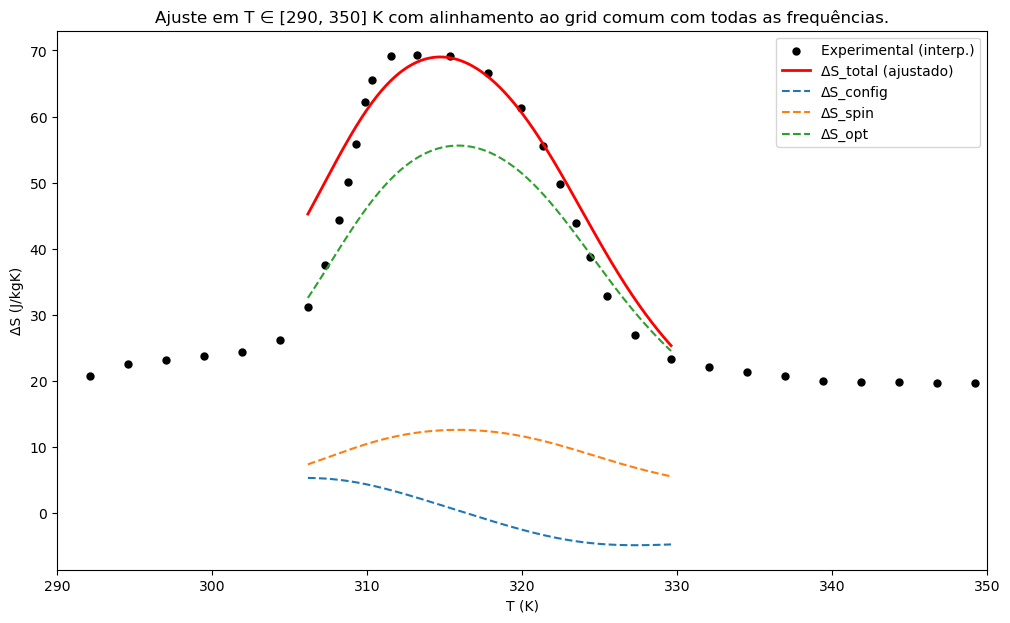

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from random import randint
data = pd.read_csv("modos_normais_oct.csv",decimal=",")
##########################################################
# Constantes
##########################################################
R = 8.314 # J/molK
k_B = 1.380649e-23
mu_B = 9.2740100783e-24
M = 0.540273 # kg/mol

##########################################################
# Frequencias utilizadas
##########################################################
data = pd.read_csv("modos_normais_oct.csv",decimal=",")
#frequencias_HS = data[data["HighSpin"]<1000]["HighSpin"]
#frequencias_LS = data[data["LowSpin"]<1000]["LowSpin"]
frequencias_HS = data["HighSpin"]
frequencias_LS = data["LowSpin"]
#freq_HS = list(freq_HS)
#freq_LS = list(freq_LS)
#frequencias_HS=(20,545.3,965.2)
#frequencias_LS=(74,545.6,968.5)
##########################################################

##########################################################
# Funções auxiliares
##########################################################
def T_model(m, delta_0, delta_V, P, g, T0):
    P_linha = (((delta_V) * P)) / 4
    gamma = (delta_0 + P_linha/k_B) / (T0)
    numerator = 2 * (m - gamma)
    denominator = np.log((m + 1) / (g**2 * (1 - m)))
    return T0 * (numerator / denominator)

def S_C(n_hs):
    return -R/M*(n_hs*np.log(n_hs) + (1-n_hs)*np.log(1-n_hs))

def S_S(T, g_J, J, B):
    x = (g_J * mu_B * J * B) / (k_B * T)
    num = np.sinh((2 * J + 1) * x / (2 * J))
    den = np.sinh(x / (2 * J))
    Z = num / den
    coeff = (2 * J + 1) / (2 * J)
    B_J = (coeff / np.tanh(coeff * x)) - (1 / (2 * J * np.tanh(x / (2 * J))))
    return R/M * (np.log(Z) + x * B_J)

def S_O(limite_soma, T, frequencias_cm):
    hbar = 1.054571817e-34
    c = 1
    beta = 1/(k_B*T)
    soma = 0.0
    for omega_cm in frequencias_cm:
        omega = 2*np.pi*c*omega_cm
        x = beta*hbar*omega
        if x == 0: 
            continue
        termo_log = -np.log(1 - np.exp(-x))
        termo_fracao = x/(np.exp(x) - 1)
        soma += termo_log + termo_fracao
    return R/M * soma

##########################################################
# Cálculo de ΔS e componentes no grid pedido (T_common)
##########################################################
def calc_deltaS_components(params, fixed, T_common, P_amb=101325, P_high=200e6,
                           freq_HS=frequencias_HS, freq_LS=frequencias_LS):
    # Usa valores fixos + ajustáveis
    T0      = params.get("T0",     fixed["T0"])
    g       = params.get("g",      fixed["g"])
    Delta0  = params.get("Delta0", fixed["Delta0"])
    delta_V = params.get("deltaV", fixed["deltaV"])

    # Varredura em m -> gera T(m) para 1 atm e 2 kbar
    m_vals = np.linspace(-0.999, 0.999, 10000)
    Temp_amb  = T_model(m_vals, Delta0, delta_V, P_amb,  g, T0)
    Temp_high = T_model(m_vals, Delta0, delta_V, P_high, g, T0)
    n_hs_vals = (m_vals+1)/2

    # Interpolar fração HS para T_common
    n_hs_amb  = np.interp(T_common, Temp_amb,  n_hs_vals)
    n_hs_high = np.interp(T_common, Temp_high, n_hs_vals)

    # (1) Configuracional
    delta_S_Config = -(S_C(n_hs_high) - S_C(n_hs_amb))

    # (2) Spin
    S_S_amb  = n_hs_amb  * S_S(T_common, 2, 2, 0.01)
    S_S_high = n_hs_high * S_S(T_common, 2, 2, 0.01)
    delta_S_Spin = -(S_S_high - S_S_amb)

    # (3) Óptica
    freq_HS=list(frequencias_HS)
    freq_LS=list(frequencias_LS)
    S_O_HS = np.array([S_O(len(freq_HS), T, freq_HS) for T in T_common])
    S_O_LS = np.array([S_O(len(freq_LS), T, freq_LS) for T in T_common])
    S_O_high = n_hs_high*S_O_HS + (1-n_hs_high)*S_O_LS
    S_O_amb  = n_hs_amb *S_O_HS + (1-n_hs_amb )*S_O_LS
    delta_S_O = -(S_O_high - S_O_amb)

    delta_S_total = delta_S_Config + delta_S_Spin + delta_S_O
    return delta_S_total, delta_S_Config, delta_S_Spin, delta_S_O

##########################################################
# Alinhar dados ao grid comum e limitar intervalo de fit
##########################################################
def align_to_common_grid(T_exp, DS_exp, T_range=None, n_points=None):
    """Cria T_common igualmente espaçado dentro de T_range
       e interpola DS_exp para T_common.
    """
    # Limpeza, ordenação e máscara de intervalo
    T_exp = np.asarray(T_exp)
    DS_exp = np.asarray(DS_exp)
    # ordenar
    order = np.argsort(T_exp)
    T_exp = T_exp[order]
    DS_exp = DS_exp[order]
    # remover temperaturas duplicadas (mantém a média do DS nelas)
    T_unique, idxs = np.unique(T_exp, return_index=True)
    if len(T_unique) != len(T_exp):
        # média por temperatura
        df_tmp = pd.DataFrame({"T":T_exp, "DS":DS_exp}).groupby("T", as_index=False).mean()
        T_exp = df_tmp["T"].values
        DS_exp = df_tmp["DS"].values

    # intervalo
    if T_range is not None:
        tmin, tmax = T_range
        mask = (T_exp >= tmin) & (T_exp <= tmax)
        T_exp = T_exp[mask]
        DS_exp = DS_exp[mask]

    if n_points is None:
        n_points = len(T_exp)  # por padrão: mesmo nº de pontos do experimento no intervalo

    # criar grid comum e interpolar DS experimental nele
    T_common = np.linspace(T_exp.min(), T_exp.max(), 500)
    DS_exp_common = np.interp(T_common, T_exp, DS_exp)

    return T_common, DS_exp_common

##########################################################
# Rotina de ajuste (com intervalo e alinhamento)
##########################################################
def fit_params(T_exp, DS_exp, to_fit=("g","Delta0"),
               init_guess={"T0":310,"g":4000,"Delta0":2500,"deltaV":43e-30},
               bounds={"T0":(200,400),"g":(1000,10000),"Delta0":(1000,5000),"deltaV":(1e-31,1e-28)},
               T_range=(290,350), n_points=None,
               freq_HS=frequencias_HS, freq_LS=frequencias_LS,
               P_amb=101325, P_high=200e6):

    # Alinhar e interpolar experimental → T_common no intervalo escolhido
    T_common, DS_exp_common = align_to_common_grid(T_exp, DS_exp, T_range=T_range, n_points=n_points)

    fixed = init_guess.copy()
    var_names = list(to_fit)
    x0   = [init_guess[p] for p in var_names]
    bnds = np.array([bounds[p] for p in var_names]).T  # shape (2, n)

    def residuals(x):
        params = {p:val for p,val in zip(var_names, x)}
        DS_model,_,_,_ = calc_deltaS_components(params, fixed, T_common,
                                                P_amb=P_amb, P_high=P_high,
                                                freq_HS=frequencias_HS, freq_LS=frequencias_LS)
        return DS_model - DS_exp_common

    res = least_squares(residuals, x0, bounds=bnds)
    fitted = {p:val for p,val in zip(var_names, res.x)}

    # Curvas finais (total e componentes) já no T_common
    DS_fit, DS_conf, DS_spin, DS_opt = calc_deltaS_components(fitted, fixed, T_common,
                                                              P_amb=P_amb, P_high=P_high,
                                                              freq_HS=frequencias_HS, freq_LS=frequencias_LS)
    out = {
        "fitted_params": fitted,
        "result": res,
        "T_common": T_common,
        "DS_exp_common": DS_exp_common,
        "DS_fit": DS_fit,
        "DS_conf": DS_conf,
        "DS_spin": DS_spin,
        "DS_opt": DS_opt
    }
    return out

##########################################################
# Exemplo de uso
##########################################################
# Carregar dados experimentais (ajuste seu mapeamento de colunas)
data = pd.read_csv("delta_S_p2_rev_comp.csv", header=None).rename(columns={0:"T(K)",2:"DS(J/kgK)"})
T_exp  = data["T(K)"].values
DS_exp = data["DS(J/kgK)"].values

# Rodar ajuste no intervalo 290–350 K, usando mesmo nº de pontos do experimento nesse intervalo
out = fit_params(T_exp, DS_exp,
                 to_fit=("g","Delta0","T0"),  # parametros a serem fitados
                 init_guess={"T0":250,"g":10000,"Delta0":4000,"deltaV":43e-30},
                 bounds={"T0":(100,650),"g":(1000,20000),"Delta0":(1000,5000),"deltaV":(10e-30,90e-30)},
                 T_range=(305,330), n_points=None)

print("Parâmetros ajustados:", out["fitted_params"])

# Plot: ajuste total + componentes no grid comum
plt.figure(figsize=(12,7))
plt.scatter(data["T(K)"].values, data["DS(J/kgK)"].values, label="Experimental (interp.)", s=25,color='black')
plt.plot(out["T_common"], out["DS_fit"],  label="ΔS_total (ajustado)", linewidth=2,color='red')
plt.plot(out["T_common"], out["DS_conf"], label="ΔS_config", ls="--")
plt.plot(out["T_common"], out["DS_spin"], label="ΔS_spin",  ls="--")
plt.plot(out["T_common"], out["DS_opt"],  label="ΔS_opt",   ls="--")
plt.xlabel("T (K)")
plt.ylabel("ΔS (J/kgK)")
plt.title("Ajuste em T ∈ [290, 350] K com alinhamento ao grid comum com todas as frequências.")
plt.legend()
plt.xlim(290,350)
plt.show()


Parâmetros ajustados: {'g': 3305.9045218279985, 'Delta0': 2493.139709444582, 'T0': 297.05073703597895}


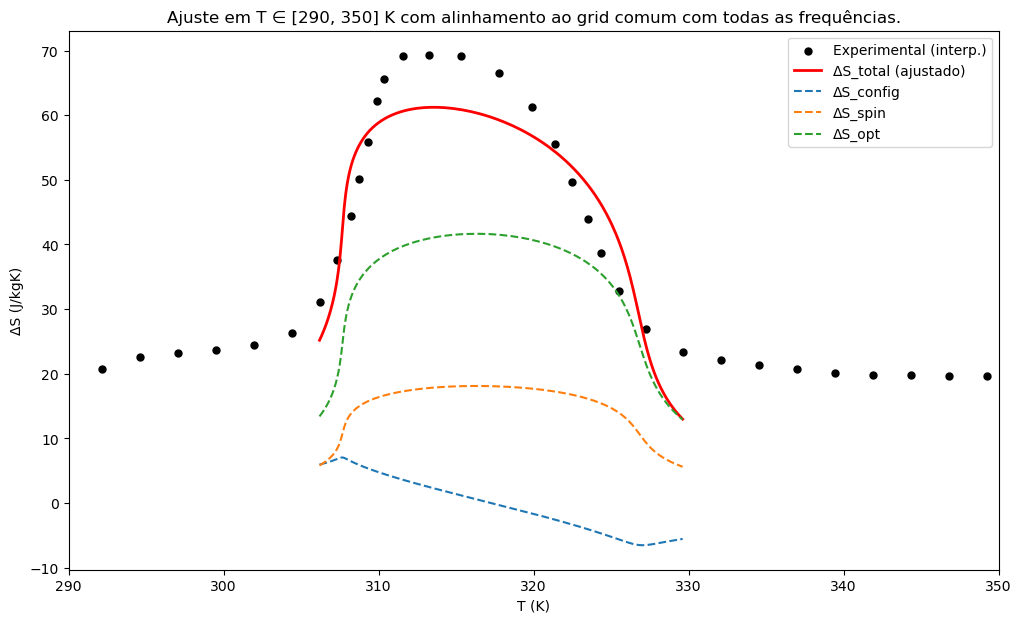

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from random import randint
data = pd.read_csv("modos_normais_oct.csv",decimal=",")
##########################################################
# Constantes
##########################################################
R = 8.314 # J/molK
k_B = 1.380649e-23
mu_B = 9.2740100783e-24
M = 0.540273 # kg/mol

##########################################################
# Frequencias utilizadas
##########################################################
#data = pd.read_csv("modos_normais_oct.csv",decimal=",")
#frequencias_HS = data[data["HighSpin"]<1000]["HighSpin"]
#frequencias_LS = data[data["LowSpin"]<1000]["LowSpin"]
#frequencias_HS = data["HighSpin"]
#frequencias_LS = data["LowSpin"]
#freq_HS = list(freq_HS)
#freq_LS = list(freq_LS)
#frequencias_HS=(20,545.3,965.2)
#frequencias_LS=(74,545.6,968.5)
frequencias_HS = [
    12.773, 16.899, 28.059, 42.117, 44.043, 53.386, 55.977, 63.688, 68.321, 76.573,
    83.482, 102.79, 104.894, 123.162, 125.2, 142.887, 145.482, 161.167, 171.985, 183.066
]
frequencias_LS = [
    15.609, 23.364, 37.934, 48.962, 49.194, 54.412, 60.235, 69.692, 75.063, 84.41,
    101.766, 122.761, 138.193, 143.381, 149.013, 181.492, 184.691, 204.834, 214.595, 253.229
]
##########################################################

##########################################################
# Funções auxiliares
##########################################################
def T_model(m, delta_0, delta_V, P, g, T0):
    P_linha = (((delta_V) * P)) / 4
    gamma = (delta_0 + P_linha/k_B) / (T0)
    numerator = 2 * (m - gamma)
    denominator = np.log((m + 1) / (g**2 * (1 - m)))
    return T0 * (numerator / denominator)

def S_C(n_hs):
    return -R/M*(n_hs*np.log(n_hs) + (1-n_hs)*np.log(1-n_hs))

def S_S(T, g_J, J, B):
    x = (g_J * mu_B * J * B) / (k_B * T)
    num = np.sinh((2 * J + 1) * x / (2 * J))
    den = np.sinh(x / (2 * J))
    Z = num / den
    coeff = (2 * J + 1) / (2 * J)
    B_J = (coeff / np.tanh(coeff * x)) - (1 / (2 * J * np.tanh(x / (2 * J))))
    return R/M * (np.log(Z) + x * B_J)

def S_O(limite_soma, T, frequencias_cm):
    hbar = 1.054571817e-34
    c = 1
    beta = 1/(k_B*T)
    soma = 0.0
    for omega_cm in frequencias_cm:
        omega = 2*np.pi*c*omega_cm
        x = beta*hbar*omega
        if x == 0: 
            continue
        termo_log = -np.log(1 - np.exp(-x))
        termo_fracao = x/(np.exp(x) - 1)
        soma += termo_log + termo_fracao
    return R/M * soma

##########################################################
# Cálculo de ΔS e componentes no grid pedido (T_common)
##########################################################
def calc_deltaS_components(params, fixed, T_common, P_amb=101325, P_high=200e6,
                           freq_HS=frequencias_HS, freq_LS=frequencias_LS):
    # Usa valores fixos + ajustáveis
    T0      = params.get("T0",     fixed["T0"])
    g       = params.get("g",      fixed["g"])
    Delta0  = params.get("Delta0", fixed["Delta0"])
    delta_V = params.get("deltaV", fixed["deltaV"])

    # Varredura em m -> gera T(m) para 1 atm e 2 kbar
    m_vals = np.linspace(-0.999, 0.999, 10000)
    Temp_amb  = T_model(m_vals, Delta0, delta_V, P_amb,  g, T0)
    Temp_high = T_model(m_vals, Delta0, delta_V, P_high, g, T0)
    n_hs_vals = (m_vals+1)/2

    # Interpolar fração HS para T_common
    n_hs_amb  = np.interp(T_common, Temp_amb,  n_hs_vals)
    n_hs_high = np.interp(T_common, Temp_high, n_hs_vals)

    # (1) Configuracional
    delta_S_Config = -(S_C(n_hs_high) - S_C(n_hs_amb))

    # (2) Spin
    S_S_amb  = n_hs_amb  * S_S(T_common, 2, 2, 0.01)
    S_S_high = n_hs_high * S_S(T_common, 2, 2, 0.01)
    delta_S_Spin = -(S_S_high - S_S_amb)

    # (3) Óptica
    freq_HS=list(frequencias_HS)
    freq_LS=list(frequencias_LS)
    S_O_HS = np.array([S_O(len(freq_HS), T, freq_HS) for T in T_common])
    S_O_LS = np.array([S_O(len(freq_LS), T, freq_LS) for T in T_common])
    S_O_high = n_hs_high*S_O_HS + (1-n_hs_high)*S_O_LS
    S_O_amb  = n_hs_amb *S_O_HS + (1-n_hs_amb )*S_O_LS
    delta_S_O = -(S_O_high - S_O_amb)

    delta_S_total = delta_S_Config + delta_S_Spin + delta_S_O
    return delta_S_total, delta_S_Config, delta_S_Spin, delta_S_O

##########################################################
# Alinhar dados ao grid comum e limitar intervalo de fit
##########################################################
def align_to_common_grid(T_exp, DS_exp, T_range=None, n_points=None):
    """Cria T_common igualmente espaçado dentro de T_range
       e interpola DS_exp para T_common.
    """
    # Limpeza, ordenação e máscara de intervalo
    T_exp = np.asarray(T_exp)
    DS_exp = np.asarray(DS_exp)
    # ordenar
    order = np.argsort(T_exp)
    T_exp = T_exp[order]
    DS_exp = DS_exp[order]
    # remover temperaturas duplicadas (mantém a média do DS nelas)
    T_unique, idxs = np.unique(T_exp, return_index=True)
    if len(T_unique) != len(T_exp):
        # média por temperatura
        df_tmp = pd.DataFrame({"T":T_exp, "DS":DS_exp}).groupby("T", as_index=False).mean()
        T_exp = df_tmp["T"].values
        DS_exp = df_tmp["DS"].values

    # intervalo
    if T_range is not None:
        tmin, tmax = T_range
        mask = (T_exp >= tmin) & (T_exp <= tmax)
        T_exp = T_exp[mask]
        DS_exp = DS_exp[mask]

    if n_points is None:
        n_points = len(T_exp)  # por padrão: mesmo nº de pontos do experimento no intervalo

    # criar grid comum e interpolar DS experimental nele
    T_common = np.linspace(T_exp.min(), T_exp.max(), 500)
    DS_exp_common = np.interp(T_common, T_exp, DS_exp)

    return T_common, DS_exp_common

##########################################################
# Rotina de ajuste (com intervalo e alinhamento)
##########################################################
def fit_params(T_exp, DS_exp, to_fit=("g","Delta0"),
               init_guess={"T0":310,"g":4000,"Delta0":2500,"deltaV":43e-30},
               bounds={"T0":(200,400),"g":(1000,10000),"Delta0":(1000,5000),"deltaV":(1e-31,1e-28)},
               T_range=(290,350), n_points=None,
               freq_HS=frequencias_HS, freq_LS=frequencias_LS,
               P_amb=101325, P_high=200e6):

    # Alinhar e interpolar experimental → T_common no intervalo escolhido
    T_common, DS_exp_common = align_to_common_grid(T_exp, DS_exp, T_range=T_range, n_points=n_points)

    fixed = init_guess.copy()
    var_names = list(to_fit)
    x0   = [init_guess[p] for p in var_names]
    bnds = np.array([bounds[p] for p in var_names]).T  # shape (2, n)

    def residuals(x):
        params = {p:val for p,val in zip(var_names, x)}
        DS_model,_,_,_ = calc_deltaS_components(params, fixed, T_common,
                                                P_amb=P_amb, P_high=P_high,
                                                freq_HS=frequencias_HS, freq_LS=frequencias_LS)
        return DS_model - DS_exp_common

    res = least_squares(residuals, x0, bounds=bnds)
    fitted = {p:val for p,val in zip(var_names, res.x)}

    # Curvas finais (total e componentes) já no T_common
    DS_fit, DS_conf, DS_spin, DS_opt = calc_deltaS_components(fitted, fixed, T_common,
                                                              P_amb=P_amb, P_high=P_high,
                                                              freq_HS=frequencias_HS, freq_LS=frequencias_LS)
    out = {
        "fitted_params": fitted,
        "result": res,
        "T_common": T_common,
        "DS_exp_common": DS_exp_common,
        "DS_fit": DS_fit,
        "DS_conf": DS_conf,
        "DS_spin": DS_spin,
        "DS_opt": DS_opt
    }
    return out

##########################################################
# Exemplo de uso
##########################################################
# Carregar dados experimentais (ajuste seu mapeamento de colunas)
data = pd.read_csv("delta_S_p2_rev_comp.csv", header=None).rename(columns={0:"T(K)",2:"DS(J/kgK)"})
T_exp  = data["T(K)"].values
DS_exp = data["DS(J/kgK)"].values

# Rodar ajuste no intervalo 290–350 K, usando mesmo nº de pontos do experimento nesse intervalo
out = fit_params(T_exp, DS_exp,
                 to_fit=("g","Delta0","T0"),  # parametros a serem fitados
                 init_guess={"T0":250,"g":10000,"Delta0":4000,"deltaV":43e-30},
                 bounds={"T0":(100,650),"g":(1000,20000),"Delta0":(1000,5000),"deltaV":(10e-30,90e-30)},
                 T_range=(305,330), n_points=None)

print("Parâmetros ajustados:", out["fitted_params"])

# Plot: ajuste total + componentes no grid comum
plt.figure(figsize=(12,7))
plt.scatter(data["T(K)"].values, data["DS(J/kgK)"].values, label="Experimental (interp.)", s=25,color='black')
plt.plot(out["T_common"], out["DS_fit"],  label="ΔS_total (ajustado)", linewidth=2,color='red')
plt.plot(out["T_common"], out["DS_conf"], label="ΔS_config", ls="--")
plt.plot(out["T_common"], out["DS_spin"], label="ΔS_spin",  ls="--")
plt.plot(out["T_common"], out["DS_opt"],  label="ΔS_opt",   ls="--")
plt.xlabel("T (K)")
plt.ylabel("ΔS (J/kgK)")
plt.title("Ajuste em T ∈ [290, 350] K com alinhamento ao grid comum com todas as frequências.")
plt.legend()
plt.xlim(290,350)
plt.show()
